<a href="https://colab.research.google.com/github/hun9008/ML_TeamProject_24SS/blob/main/Roc_F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data/

/content/drive/.shortcut-targets-by-id/1G6SgIRKCYt5sUkkaCAiAmdP0_hZA-rFs/data


In [3]:
ls

blurr_cut_png/   Final_data/  images_cut2_png/  images_jpg/  incipient/  no/
cut_resize_png/  first_data/  images_gray_jpg/  images_png/  mature/     overripe/


In [4]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [5]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [6]:
pip install vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 729.7 kB/s eta 0:00:00


In [7]:
import tensorflow as tf
import os
import pickle
import optuna
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_addons as tfa
from vit_keras import vit
from vit_keras import visualize


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


1 Physical GPUs, 1 Logical GPUs


In [8]:
images_final_data_path = '/content/drive/My Drive/data/Final_data/'

In [9]:
os.chdir(images_final_data_path)
!ls

grad_cam.jpg  incipient  mature  no  overripe


In [10]:
image_path = images_final_data_path

Pickle load to variable

In [11]:
os.chdir(os.path.join(image_path, 'overripe'))
with open('zero_centering.pkl', 'rb') as f:
     overripe = pickle.load(f)
     print('overripe : ', len(overripe))
os.chdir(os.path.join(image_path, 'no'))
with open('zero_centering.pkl', 'rb') as f:
     no = pickle.load(f)
     print('no : ', len(no))

os.chdir(os.path.join(image_path, 'mature'))
with open('zero_centering.pkl', 'rb') as f:
     mature = pickle.load(f)
     print('mature : ', len(mature))

os.chdir(os.path.join(image_path, 'incipient'))
with open('zero_centering.pkl', 'rb') as f:
     incipient = pickle.load(f)
     print('incipient : ', len(incipient))

overripe :  2000
no :  2000
mature :  2000
incipient :  2000


Dictionary to numpy array

In [12]:
# overripe의 모든 사진에 대해 반복
overripe_data_list = []

for filename, data in overripe.items():
    zero_centering_value = data.get('zero_centering')
    overripe_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
overripe_data = np.array(overripe_data_list)

# 확인을 위해 배열의 크기 출력
print("overripe_data shape:", overripe_data.shape)
no_data_list = []

for filename, data in no.items():
    zero_centering_value = data.get('zero_centering')
    no_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
no_data = np.array(no_data_list)

# 확인을 위해 배열의 크기 출력
print("no_data shape:", no_data.shape)

mature_data_list = []

for filename, data in mature.items():
    zero_centering_value = data.get('zero_centering')
    mature_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
mature_data = np.array(mature_data_list)

# 확인을 위해 배열의 크기 출력
print("mature_data shape:", mature_data.shape)

incipient_data_list = []

for filename, data in incipient.items():
    zero_centering_value = data.get('zero_centering')
    incipient_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
incipient_data = np.array(incipient_data_list)

# 확인을 위해 배열의 크기 출력
print("incipient_data shape:", incipient_data.shape)

overripe_data shape: (2000, 224, 224, 3)
no_data shape: (2000, 224, 224, 3)
mature_data shape: (2000, 224, 224, 3)
incipient_data shape: (2000, 224, 224, 3)


Train Val Test split (0.75:0.15:0.15)

In [13]:
# 데이터를 train/validation/test로 나누기
X = np.concatenate((overripe_data, no_data, mature_data, incipient_data), axis=0)
y = np.concatenate((np.zeros(overripe_data.shape[0]), np.ones(no_data.shape[0]),
                    2*np.ones(mature_data.shape[0]), 3*np.ones(incipient_data.shape[0])))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5600, 224, 224, 3)
(1200, 224, 224, 3)
(1200, 224, 224, 3)


y one-hot

In [14]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

Training & Test

In [15]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)

353253686/353253686 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5600, 224, 224, 3)
(1200, 224, 224, 3)
(1200, 224, 224, 3)


In [17]:
X_train.all()

False

In [18]:
#def train_vgg16_model():

  #Freeze the base model layers
  #for layer in base_model.layers:
  #    layer.trainable = False

# Add custom top layers for classification
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

  # Compile model
  # optimizer = Adam(lr=5.520238899015578e-05)
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
                loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                metrics = ['accuracy'])
batch_size = 16

model.compile(optimizer = optimizer,
                loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                metrics = ['accuracy'])

batch_size = 16

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                factor = 0.2,
                                                patience = 2,
                                                verbose = 1,
                                                min_delta = 1e-4,
                                                min_lr = 1e-6,
                                                mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                min_delta = 1e-4,
                                                patience = 5,
                                                mode = 'max',
                                                restore_best_weights = True,
                                                verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = X_train,
          y = y_train_one_hot,
          # steps_per_epoch = batch_size,
          validation_data = (X_val, y_val_one_hot),
          # validation_steps = batch_size,
          epochs = 50,
          callbacks = callbacks)


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 4)          

In [19]:
y_pred_prob = model.predict(X_test)

38/38 [==============================] - 5s 46ms/step


In [20]:
print(y_pred_prob.shape)

(1200, 4)


In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print('Test accuracy:', test_acc)

38/38 [==============================] - 2s 46ms/step - loss: 0.8340 - accuracy: 0.8375
Test accuracy: 0.8374999761581421


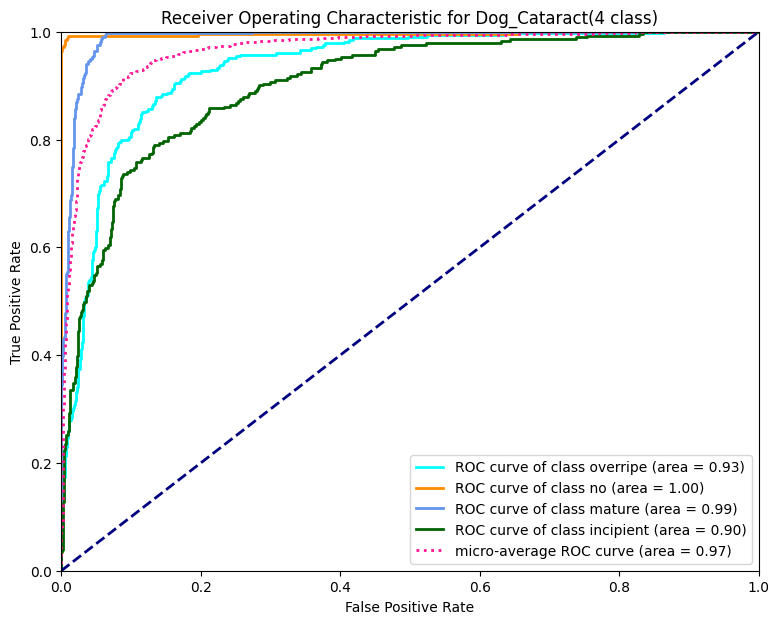

In [22]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC 커브 계산 및 그리기
fpr = {}
tpr = {}
roc_auc = {}
class_name = ["overripe", "no", "mature", "incipient"]

for i, name in enumerate(class_name):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average ROC 커브
fpr["dog_Cataract"], tpr["dog_Cataract"], _ = roc_curve(y_test_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["dog_Cataract"] = auc(fpr["dog_Cataract"], tpr["dog_Cataract"])

# ROC 커브 그리기
plt.figure(figsize = (9, 7))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name[i], roc_auc[i]))

plt.plot(fpr["dog_Cataract"], tpr["dog_Cataract"], color='deeppink', linestyle=':', linewidth=2, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["dog_Cataract"]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Dog_Cataract(4 class)')
plt.legend(loc="lower right")
plt.show()

In [23]:
#Precision-Recall F1 Score
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = {}
precision = {}
recall = {}
class_name = ["overripe", "no", "mature", "incipient"]
for i, name in enumerate(class_name):
    y_pred_binary = np.round(y_pred_prob[:, i])
    f1[name] = f1_score(y_test_one_hot[:, i], y_pred_binary)
    precision[name] = precision_score(y_test_one_hot[:, i], y_pred_binary)
    recall[name] = recall_score(y_test_one_hot[:, i], y_pred_binary)

y_pred_binary_all = np.round(y_pred_prob.ravel())
f1["Dog_Cataract"] = f1_score(y_test_one_hot.ravel(), y_pred_binary_all)
precision["Dog_Cataract"] = precision_score(y_test_one_hot.ravel(), y_pred_binary_all)
recall["Dog_Cataract"] = recall_score(y_test_one_hot.ravel(), y_pred_binary_all)

<Figure size 1600x1200 with 0 Axes>

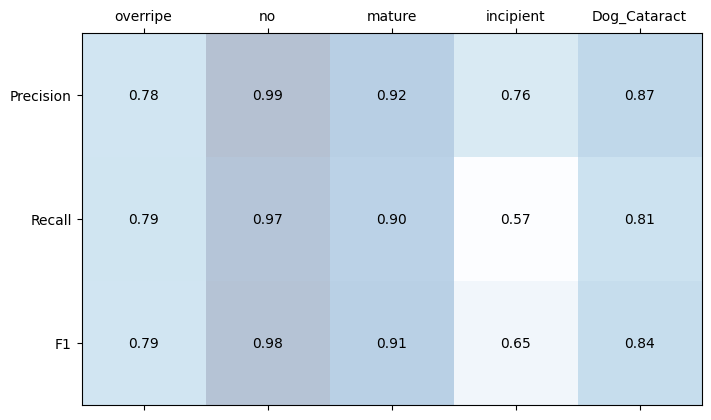

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
x = ["overripe", "no", "mature", "incipient", "Dog_Cataract"]
y = ["Precision", "Recall", "F1"]

f1_score_list = []
precision_score_list = []
recall_score_list = []
for i in x:
    precision_score_list.append(precision[i])
    recall_score_list.append(recall[i])
    f1_score_list.append(f1[i])
score_list = np.array([precision_score_list, recall_score_list, f1_score_list])
plt.figure(figsize = (16, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )